classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
super_classes = ['directions', 'commands', 'binary_commands']
directions = left, right, up, down
commands = stop, go
binary_commands = on, off, yes, no

In [1]:
import random
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
warnings.filterwarnings("ignore")
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Sub-class classifier

In [ ]:
# create dict for feature extraction
classes =  ['no', 'yes', 'down', 'up', 'left', 'right', 'on', 'off', 'stop', 'go']
parent_dir = ''
file_dict = { 'wav_file' : [], 'class': [], 'fold':[]}

for i in classes:
    class_dir = parent_dir+i
    files = [class_dir + '/' + j for j in os.listdir(class_dir)]
    fold = [random.randint(1,10) for i in range(len(files))]
    file_dict['wav_file'] += files
    file_dict['class'] += [i]*len(files)
    file_dict['fold'] += fold
print(file_dict)
df= pd.DataFrame(file_dict)
print(df)

In [47]:
# extract mel spectrograms
def extract_melspectrogram(wavpath, sample_rate=16000):
    sample_rate = 16000
    window_size = .025
    window_stride = 0.01
    n_dft = 512
    win_length = int(sample_rate * window_size)
    hop_length = int(sample_rate * window_stride)
    y, sr = librosa.load(wavpath, sr=sample_rate)
    y = y - y.mean()
    y = np.append(y[0],y[1:]-.97*y[:-1])
    # compute mel spectrogram
    stft = librosa.stft(y, n_fft=n_dft, hop_length=hop_length,
        win_length=win_length, window=scipy.signal.hamming)
    spec = np.abs(stft)**2
    mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=n_dft, n_mels=40, fmin=20)
    melspec = np.dot(mel_basis, spec)
    logspec = librosa.power_to_db(melspec, ref=np.max)
    logspec = np.transpose(logspec)
    if (logspec.shape[0] != 101): #zero pad short utterances
        zero_pad = np.zeros((101-logspec.shape[0], 40),dtype=np.float32)
        logspec= np.vstack((logspec,zero_pad))
    return logspec

In [48]:
# calculate mel spectrograms of each wav file
features=[]
labels=[]
folds=[]
sr=16000
for i in range(len(df)):
    fold=df["fold"].iloc[i]
    path=df["wav_file"].iloc[i]
    label = df["class"].iloc[i]
    mfccs = extract_melspectrogram(path, sr)
    features.append(mfccs)
    folds.append(fold)
    labels.append(label)
# encodel categorical labels
le = LabelEncoder()
labels = le.fit_transform(labels)
features=torch.tensor(features)
labels=torch.tensor(labels)
folds=torch.tensor(folds)
# Saving the dataset to disk to prevent re-Loading
torch.save(features, "model_outputs/all_features_mfccs.pt")
torch.save(labels, "model_outputs/all_labels.pt")
torch.save(folds, "model_outputs/all_folds.pt")

In [2]:
# START RUNNING CODE HERE (for classifier on 10 classes)
# load dataset for subclass classifier
features=torch.load("model_outputs/all_features_mfccs.pt")#.to(device)
labels=torch.load("model_outputs/all_labels.pt")#.to(device)
folds=torch.load("model_outputs/all_folds.pt")#.to(device)

In [3]:
# omit test fold from dataset
def get_dataset(skip_fold):
    local_features=[]
    local_labels=[]
    for i in range(len(folds)):
        #if folds[i]==skip_fold:
        #    continue
        local_features.append(features[i])
        local_labels.append(labels[i])
    local_features=torch.stack(local_features)
    local_labels=torch.stack(local_labels)
    print("Entire dataset size: ", local_features.size())
    return TensorDataset(local_features, local_labels)

In [4]:
# initialize dataset
dataset=get_dataset(skip_fold=10)
# split data into training and validation sets
val_size=int(0.1*len(dataset))
train_size=len(dataset)-val_size
train_ds, val_ds=random_split(dataset, [train_size, val_size])
print("Number of training samples: ", len(train_ds))
print("Number of validation samples: ", len(val_ds))

# initialize data loader
batch_size=128
train_loader=DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader=DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

Entire dataset size:  torch.Size([23682, 101, 40])
Number of training samples:  21314
Number of validation samples:  2368


In [18]:
# define model
output_size = 3
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Model with two CNN layers followed by two fully-connected layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        #self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 1000, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        #x = F.relu(self.conv3(x))
        #x = self.pool(x)

        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# verify model shape and dimensions will work with input data   
#model = MyModel()
#print(model)
#input = torch.randn(128, 1, 101, 40)
#model(input)
#print(model(input).shape)

In [6]:
# Training loop
def train_network(model, train_loader, val_loader, criterion, optimizer, start_epoch, end_epoch):
    for epoch in range(start_epoch, end_epoch):
        for i, (inputs, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            inputs = inputs.unsqueeze(1)#.to('cuda')
            #labels = labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

        # Calculate accuracy of this training epoch
        acc = 0
        count = 0
        for inputs, labels in val_loader:
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            acc += (torch.argmax(outputs, 1) == labels).float().sum()
            count += len(labels)
        acc /= count
        print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))
        
# Test model
def test_network(model, val_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs =inputs.unsqueeze(1)#.to('cuda')
            #labels = labels.to('cuda')
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Test accuracy: %d %%' % (100 * correct / total))

In [12]:
# Train model from scratch
# Instantiate the model, loss function, and optimizer
model = MyModel()
#model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
start_epoch = 0
end_epoch = 20
train_network(model, train_loader, val_loader, criterion, optimizer, start_epoch, end_epoch)
test_network(model, val_loader)


Epoch 0: model accuracy 44.09%
Epoch 1: model accuracy 64.02%
Epoch 2: model accuracy 75.38%
Epoch 3: model accuracy 78.72%
Epoch 4: model accuracy 81.38%
Epoch 5: model accuracy 86.53%
Epoch 6: model accuracy 85.60%
Epoch 7: model accuracy 85.43%
Epoch 8: model accuracy 86.15%
Epoch 9: model accuracy 88.18%
Epoch 10: model accuracy 88.39%
Epoch 11: model accuracy 88.51%
Epoch 12: model accuracy 88.72%
Epoch 13: model accuracy 87.50%
Epoch 14: model accuracy 89.74%
Epoch 15: model accuracy 88.47%
Epoch 16: model accuracy 89.27%
Epoch 17: model accuracy 89.19%
Epoch 18: model accuracy 89.40%
Epoch 19: model accuracy 89.10%
Test accuracy: 89 %


In [13]:
# save checkpoint
EPOCH = end_epoch
PATH = "model_outputs/sub_class_model.pt"

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

In [ ]:
# Train model from checkpoint super-class classifier (originally trained for 3 classes)
# load features for super class dataset
features=torch.load("model_outputs/super_class_all_features_mfccs.pt")#.to(device)
labels=torch.load("model_outputs/super_class_all_labels.pt")#.to(device)
folds=torch.load("model_outputs/super_class_all_folds.pt")#.to(device)

# initialize dataset
dataset_super=get_dataset(skip_fold=10)

# split data into training and validation sets
val_size=int(0.1*len(dataset_super))
train_size=len(dataset)-val_size
train_ds_super, val_ds_super=random_split(dataset_super, [train_size, val_size])
print("Number of training samples: ", len(train_ds_super))
print("Number of validation samples: ", len(val_ds_super))

# initialize data loader
batch_size=128
train_loader_super=DataLoader(train_ds_super, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader_super=DataLoader(val_ds_super, batch_size, num_workers=4, pin_memory=True)
# Instantiate the model, loss function, and optimizer
model = MyModel()
#model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
PATH = "model_outputs/super_class_model.pt"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
start_epoch = 20
end_epoch = 40
train_network(model, train_loader_super, val_loader_super, criterion, optimizer, start_epoch, end_epoch)
test_network(model, val_loader_super)

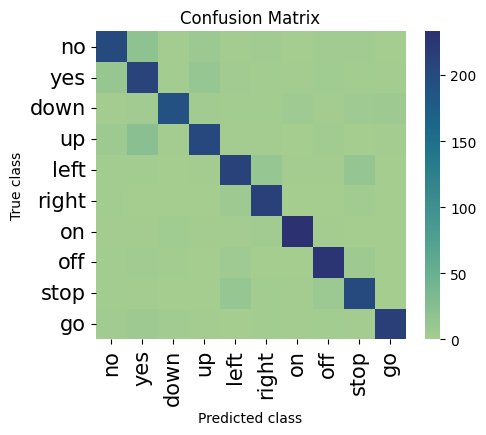

In [15]:
# plot confusion matrix
classes =  ['no', 'yes', 'down', 'up', 'left', 'right', 'on', 'off', 'stop', 'go']
confusion_matrix = torch.zeros(output_size, output_size)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        for truth, predicted in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[truth.long(), predicted.long()] += 1

plt.figure(figsize=(5,4))
df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
heatmap = sns.heatmap(df_cm, cmap="crest")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='center',fontsize=15)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title("Confusion Matrix")
plt.show()

# Super class classifier

In [21]:
super_classes =  ['directions', 'commands', 'binary_commands']
parent_dir = 'super_classes_all/'
file_dict = { 'wav_file' : [], 'class': [], 'fold':[]}

for i in super_classes:
    class_dir = parent_dir+i
    files = [class_dir + '/' + j for j in os.listdir(class_dir)]
    fold = [random.randint(1,10) for i in range(len(files))]
    file_dict['wav_file'] += files
    file_dict['class'] += [i]*len(files)
    file_dict['fold'] += fold
df= pd.DataFrame(file_dict)
print(df)
#print(file_dict)

{'wav_file': ['super_classes_all/directions/right_db8a3397_nohash_0.wav', 'super_classes_all/directions/left_0397ecda_nohash_1.wav', 'super_classes_all/directions/up_ec74a8a5_nohash_1.wav', 'super_classes_all/directions/down_6ef76186_nohash_3.wav', 'super_classes_all/directions/right_73af0c50_nohash_2.wav', 'super_classes_all/directions/up_5db0e146_nohash_0.wav', 'super_classes_all/directions/up_c5c60d8d_nohash_0.wav', 'super_classes_all/directions/down_3d6bee47_nohash_1.wav', 'super_classes_all/directions/right_0bde966a_nohash_0.wav', 'super_classes_all/directions/down_64220627_nohash_0.wav', 'super_classes_all/directions/up_8c3c4715_nohash_1.wav', 'super_classes_all/directions/up_611d2b50_nohash_4.wav', 'super_classes_all/directions/up_9886d8bf_nohash_2.wav', 'super_classes_all/directions/right_3f2b358d_nohash_0.wav', 'super_classes_all/directions/up_d197e3ae_nohash_2.wav', 'super_classes_all/directions/left_363c6bad_nohash_2.wav', 'super_classes_all/directions/down_7195ffa6_nohash_1

In [23]:
# extract features
features=[]
labels=[]
folds=[]
sr=16000
for i in range(len(df)):
    fold=df["fold"].iloc[i]
    path=df["wav_file"].iloc[i]
    label = df["class"].iloc[i]
    mfccs = extract_melspectrogram(path, sr)
    features.append(mfccs)
    folds.append(fold)
    labels.append(label)

le = LabelEncoder()
labels = le.fit_transform(labels)

In [24]:
features=torch.tensor(features)
labels=torch.tensor(labels)
folds=torch.tensor(folds)
# Saving the dataset to disk to prevent re-Loading
torch.save(features, "model_outputs/super_class_all_features_mfccs.pt")
torch.save(labels, "model_outputs/super_class_all_labels.pt")
torch.save(folds, "model_outputs/super_class_all_folds.pt")


In [16]:
# START RUNNING HERE
# load features for super class dataset
features=torch.load("model_outputs/super_class_all_features_mfccs.pt")#.to(device)
labels=torch.load("model_outputs/super_class_all_labels.pt")#.to(device)
folds=torch.load("model_outputs/super_class_all_folds.pt")#.to(device)

In [19]:
# initialize dataset
dataset=get_dataset(skip_fold=10)
# split data into training and validation sets
val_size=int(0.1*len(dataset))
train_size=len(dataset)-val_size
train_ds, val_ds=random_split(dataset, [train_size, val_size])

print("Number of training samples: ", len(train_ds))
print("Number of validation samples: ", len(val_ds))

# initialize data loader
batch_size=128
train_loader=DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader=DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)


Entire dataset size:  torch.Size([23682, 101, 40])
Number of training samples:  21314
Number of validation samples:  2368


In [21]:
# Instantiate the model, loss function, and optimizer
model = MyModel()
#model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
start_epoch = 0
end_epoch = 20
train_network(model, train_loader, val_loader, criterion, optimizer, start_epoch, end_epoch)
test_network(model, val_loader)


Epoch 0: model accuracy 57.31%
Epoch 1: model accuracy 67.10%
Epoch 2: model accuracy 71.07%
Epoch 3: model accuracy 75.30%
Epoch 4: model accuracy 76.94%
Epoch 5: model accuracy 80.79%
Epoch 6: model accuracy 83.02%
Epoch 7: model accuracy 83.23%
Epoch 8: model accuracy 83.74%
Epoch 9: model accuracy 86.23%
Epoch 10: model accuracy 87.29%
Epoch 11: model accuracy 87.08%
Epoch 12: model accuracy 87.96%
Epoch 13: model accuracy 87.96%
Epoch 14: model accuracy 88.60%
Epoch 15: model accuracy 88.51%
Epoch 16: model accuracy 88.22%
Epoch 17: model accuracy 88.09%
Epoch 18: model accuracy 89.02%
Epoch 19: model accuracy 89.86%
Test accuracy: 89 %


In [31]:
# save checkpoint
EPOCH = 20
PATH = "model_outputs/super_class_model.pt"

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)